In [1]:
import numpy as np
np.random.seed(1234)
import scipy
import pymc3 as pm
import theano
import theano.tensor as tt
import numba
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd

In [2]:
if not os.path.exists('./plots'):
    os.mkdir('./plots')

# for solving the equation for u
@numba.vectorize("float64(float64, float64)", nopython=True)
def kepler(M, e):
    E0 = M
    E = M
    
    for i in range(50000):
        g = E0 - e * np.sin(E0) - M
        gp = 1. - e * np.cos(E0)
        E = E0 - g / gp
        if np.abs((E - E0) / E) <= 1.234e-6:
            return E
        E0 = E
    #print("returns nan")
    return np.nan

class Kepler(theano.Op):
    def make_node(self, M, e):
        M = tt.as_tensor_variable(M)
        e = tt.as_tensor_variable(e)
        return theano.Apply(self, [M, e], [M.type()])
    
    def perform(self, node, inputs, outputs):
        M, e = inputs
        e = np.float64(e)
        outputs[0][0] = kepler(M, e)
    
    def grad(self, inputs, g):
        M, e = inputs
        E = self(M, e)
        dE_dM = 1. / (1.0 - e * tt.cos(E))
        dE_de = tt.sin(E) * dE_dM
        return dE_dM * g[0], (dE_de * g).sum()
    
    def infer_shape(self, node, i0_shapes):
        return [i0_shapes[0]]

# data creation
def true_anomaly(t,tp,e,tau):
    temp1=np.min((t-tau)/tp)-1
    temp2=np.max((t-tau)/tp)+1
    u1=np.linspace(2*np.pi*temp1,2*np.pi*temp2,1000)
    ma=u1-e*np.sin(u1)
    myfunc=scipy.interpolate.interp1d(ma,u1)
    u=myfunc((2*np.pi)*(t-tau)/tp)
    return 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(0.5*u))

def vr(t,kappa,tp,e,tau,omega,v0):
    omega=np.radians(omega)
    f=true_anomaly(t,tp,e,tau)
    return kappa*(np.cos(f+omega)+e*np.cos(omega))+v0

def create_data(num_points):
    kappa=0.15
    tp=350.0
    e=0.3
    tau=87.5
    omega=-90.0
    v0=0.0
    t = np.linspace(0,tp*2,num_points)
    vr1=vr(t,kappa,tp,e,tau,omega,v0)
    err = np.random.normal(0.,0.02,num_points) % 1e-2
    return t,vr1+err,err

In [3]:
t,rv,rv_err = create_data(500)
plt.errorbar(x=t,y=rv,yerr=rv_err,fmt='.')
plt.savefig('./plots/data.png')
plt.clf()
print(rv.mean())
print(rv_err.mean())

0.004761738338823059
0.005014625779766724


<Figure size 432x288 with 0 Axes>

In [4]:
with pm.Model() as my_model:
        #balan exofit paper
    #https://watermark.silverchair.com/mnras0394-1936.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAtMwggLPBgkqhkiG9w0BBwagggLAMIICvAIBADCCArUGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMlOR-UI7QAtiAY8_CAgEQgIIChh4btrd3dwkOoOua9LWY1G4p0hj5VmbSCZTamd-_DeAexRP3y4uwHx-YAG5FPkeiUFq5voesTmdpPgLX3YQrZPK11kPRBcbe-UAL1u_Tlu-H0VdagkwU1vQ5l5LCRqL8g3Ndnqa4b-mML1xpKMvmY5vmjD9hZsM9urVahFTWcOQeYx3YFPq9qR33Zrn6Zie4uPkpmdd25BZAUlam_uTo4jp3soq73cerr2lzTHvap_o_HrPR4jmU73jaJuk9OdgQWcsSJHVpg08cC16qx7IKyn_rQsLyF1FX4JqIaRpVdHZYpTrj42CB4lYE_Df9RjMTN0h_54mXHbaFYUu-yb9I-XsGcVQVIUj8mJash6zqwc9TZ5kULaXRJ7BZa4NSUKr-4q6xp9aPID7ipRphLpFTmR_tKbPWX2wvdeu862L0JtjrSGAoR2WZZiCa1ptDmw1VFyPO0JTtzgVqsoTyxCNm7GwYrIVb0BfUBAStq9-WwjmxAUrxsvXQqlXUQ2Lfccd6yUaOn8RuXsM8rcHXk3vf8VhEyF1cs0QUxIa9WD8O6lHXh7jHD8ssvwWe4AnFlI1_JtGxqtN4X8cjp_xMXO7OfQ1YvK7bq7zb9hf4IvHCxHJRQS_4CoGvsXKLavw7ZCbXch7CVZBZG4nYnxHZnnP5tdSJZCccA3Yy05CeFaBRF2lAt3Fdmq9sPryUCJyZLt_V7DCjk53jVyop-Lp1zHb6YmO0GqMtG-2W7e4OHht9iPQR2N0oH-HRpbg4CWl-2RXyGndo6cMVKPyGzOmPn65kllxx3yICH9rIQWfqWsHTnxL3x8Zl06iZek2sYv5fs8nK5resplk8BeZcZ4USCkDtNlgDuLWtMu4
    '''
        jeffereys prior
        T = 1 / [T * ln(tmax/tmin)]
    '''
    def jeffereys_t_logp(t, tmax=15000, tmin=0.2):
        return -tt.log(t * tt.log(tmax / tmin)) 
    '''
        modified jeffereys prior
        k = 1/(k+k0) * 1/ln(1 + kmax/k0)
    '''
    def mod_jeffereys_k_logp(k, kmax=400, k0=1):
        return -tt.log((k + k0) * tt.log( 1 + kmax/k0))
    T = pm.DensityDist("T", jeffereys_t_logp,transform=pm.distributions.transforms.log, testval = 350.)
    K = pm.DensityDist("K", mod_jeffereys_k_logp,transform=pm.distributions.transforms.Log(), testval=0.15)
    e = pm.Uniform('e', lower=0., upper=1., testval=0.3)
    w = pm.Uniform("w", lower=-2 * np.pi, upper=2 * np.pi, testval=-np.pi/2)
    tau = pm.Uniform("tau", lower=0, upper=2 * np.pi, testval=np.radians(87.5))
    M = 2 * (np.pi / T) * t - tau
    u = Kepler()(M,e)
    f = 2 * tt.arctan2(tt.sqrt(1 + e) * tt.tan(0.5 * u), tt.sqrt(1 - e))
    v0 = pm.Uniform('v0', lower=-1, upper=1)
    v_mean = v0 + K * (tt.cos(f + w) + e * tt.cos(w))
    jitter = pm.HalfNormal('jitter', sd=0.01)
    err_scale = pm.HalfNormal('err_scale', sd=1)
    sd = tt.sqrt((err_scale * rv_err) ** 2 + jitter ** 2)
    pm.Normal('y', mu=v_mean, sd=sd, observed=rv )


# ADVI

In [5]:
with my_model:
    advi = pm.ADVI(random_seed=1234)
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [6]:
approx = advi.fit(30000,obj_optimizer=pm.adam(learning_rate=0.01),callbacks=[tracker])
print("Loss at the end of training : ",approx.hist[-1])

Average Loss = -2,142: 100%|██████████| 30000/30000 [00:12<00:00, 2417.22it/s]  
Finished [100%]: Average Loss = -2,141.9


Loss at the end of training :  -2140.461362223594


In [7]:
trace = approx.sample(5000)
print(pm.summary(trace))

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


              mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
T          349.796  0.060  349.679  349.907      0.001    0.001    4777.0   
K            0.149  0.000    0.149    0.150      0.000    0.000    4760.0   
e            0.301  0.001    0.299    0.303      0.000    0.000    4912.0   
w           -1.578  0.001   -1.580   -1.575      0.000    0.000    4807.0   
tau          1.571  0.001    1.569    1.573      0.000    0.000    5035.0   
v0           0.005  0.000    0.005    0.005      0.000    0.000    4388.0   
jitter       0.002  0.000    0.002    0.003      0.000    0.000    4763.0   
err_scale    0.347  0.023    0.303    0.389      0.000    0.000    4914.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
T          4777.0    4777.0    4459.0    NaN  
K          4760.0    4762.0    4865.0    NaN  
e          4912.0    4912.0    4941.0    NaN  
w          4807.0    4814.0    5039.0    NaN  
tau        5035.0    5035.0    4712.0    NaN  
v0         4387.0    437

In [8]:
with my_model:
    ppc = pm.sample_posterior_predictive(trace,random_seed=1234)
plt.plot(t, rv, '.')
plt.plot(t, ppc['y'][-1], '-')
plt.savefig('./plots/advi.png')
print('Mean squared error of posterior samples and actual data :')
print(((rv - ppc['y'][-1])**2).mean())
plt.clf()

100%|██████████| 5000/5000 [00:06<00:00, 754.95it/s]


Mean squared error of posterior samples and actual data :
1.6596421949835818e-05


<Figure size 432x288 with 0 Axes>

# MCMC

In [9]:
#MCMC
with my_model:
    trace_nuts = pm.sample(draws=5000,random_seed=1234,chains=2,cores=2,init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err_scale, jitter, v0, tau, w, e, K, T]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:31<00:00, 351.74draws/s]


In [10]:
print(trace_nuts['e'][0:5000].mean())
print(trace_nuts['T'][0:5000].mean())
print(trace_nuts['K'][0:5000].mean())
print(trace_nuts['w'][0:5000].mean())
print(trace_nuts['tau'][0:5000].mean())
print(trace_nuts['v0'][0:5000].mean())

0.3012591281750235
349.746417009099
0.1500976898462208
-1.5766552933554772
1.5701981881169669
0.003904880031709976


In [11]:
with my_model:
    ppc_nuts = pm.sample_posterior_predictive(trace_nuts,random_seed=1234)

100%|██████████| 10000/10000 [00:13<00:00, 742.33it/s]


In [12]:
plt.plot(t, rv, '*')
plt.plot(t, ppc_nuts['y'][-1], '-',label='NUTS')
plt.savefig('./plots/nuts.png')
plt.clf()
print('Mean squared error of posterior samples and actual data :')
print(((rv - ppc_nuts['y'][-1])**2).mean())

plt.plot(t[np.arange(0,500,10)], rv[np.arange(0,500,10)], '*',label='data')
plt.plot(t[np.arange(0,500,10)], ppc['y'][-1][np.arange(0,500,10)], '-',label='advi')
plt.plot(t[np.arange(0,500,10)],ppc_nuts['y'][-1][np.arange(0,500,10)],'-',label='nuts')
plt.ylabel('radial velocity (m/s)')
plt.xlabel('time (days)')
plt.legend()
plt.savefig("./plots/final.png")
plt.clf()
plt.figure(figsize=(10,6))

Mean squared error of posterior samples and actual data :
1.9817883307325097e-05


<Figure size 720x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [13]:
import corner

/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


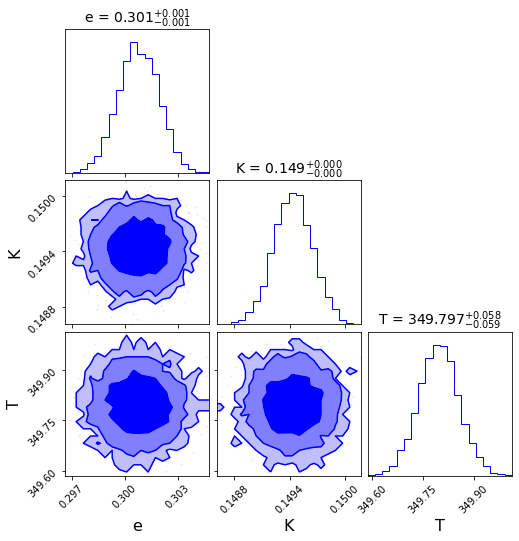

In [14]:
dn = np.asarray([trace['e'],trace['K'],trace['T']]).T
corner.corner(dn, labels=["e", "K","T"] ,levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.3f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
plt.savefig('params.png')